In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.io_utils import  load_pkl
from utils.utils import get_path
from utils.toydata_utils import get_toy_data
from utils.fig_utils import plot_edges_on_scatter, intersect_at_zero
from vis_utils.plot import plot_scatter

from sklearn.decomposition import PCA
from persim import plot_diagrams
import os
import numpy as np

env: CUDA_VISIBLE_DEVICES=1


In [2]:
style_file = "utils.style"
plt.style.use(style_file)

In [3]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Figures on cycle matching

In [5]:
dataset = "toy_circle"
pca = PCA(n_components=2)
data_seed = 0
d=50

# n=1000, Eucliean

In [7]:
sigmas = [0.1, 0.2, 0.25, 0.3, 0.35]
n=1000

In [8]:
seeds = [0, 1, 2]

all_prevs = {}

times = []

for sigma in sigmas:
    cycle_ids = []
    
    # get all matched cycles 
    for seed in seeds:
        file_name = f"toy_circle_{n}_d_50_ortho_gauss_sigma_{sigma}_seed_{data_seed}_{seed}_matching_euclidean"
        res  = load_pkl(os.path.join(root_path, dataset, file_name))
        matches_x = np.array(res[0])[:, 0]
        times.append(res[-1])
        
        cycle_ids.append(matches_x)
    cycle_ids = np.concatenate(cycle_ids)
    
    cycle_ids = np.unique(cycle_ids)
    
    # get prevalances for matched cycles
    prevs = np.zeros((len(cycle_ids), len(seeds)))

    for seed in seeds:
        file_name = f"toy_circle_{n}_d_50_ortho_gauss_sigma_{sigma}_seed_{data_seed}_{seed}_matching_euclidean"
        res  = load_pkl(os.path.join(root_path, dataset, file_name))
        matches_x = np.array(res[0])[:, 0]
        
        for i, cycle_id in enumerate(matches_x):
            ordered_ind = np.where(cycle_ids == cycle_id)[0][0]
            prevs[ordered_ind, seed] = res[1][i]
    all_prevs[sigma] = {"cycle_ids": cycle_ids, "prevs": prevs}

In [9]:
# print ids of cycles matched in more than one seed

min_seeds = 2
for sigma in sigmas:
    cycle_ids = all_prevs[sigma]["cycle_ids"]
    prevs = all_prevs[sigma]["prevs"]
    
    seeds_found = (prevs > 0).sum(1)
    
    if np.any(seeds_found > min_seeds):
        print(f"sigma: {sigma}, cycle ids:{cycle_ids[seeds_found > min_seeds]}")
    else:
        print(f"sigma: {sigma}")
        print(f"No cycle found in more than {min_seeds} seed")

sigma: 0.1, cycle ids:[1251]
sigma: 0.2
No cycle found in more than 2 seed
sigma: 0.25
No cycle found in more than 2 seed
sigma: 0.3
No cycle found in more than 2 seed
sigma: 0.35, cycle ids:[168]


## histograms

sigma: 0.1 2nd most prev: 0.33 +/- 0.47
sigma: 0.1 prev: 0.38 +/- 0.02
sigma: 0.2 prev: 0.48 +/- 0.37
sigma: 0.25 prev: 0.58 +/- 0.41
sigma: 0.3 prev: 0.52 +/- 0.37
sigma: 0.35 prev: 0.44 +/- 0.31


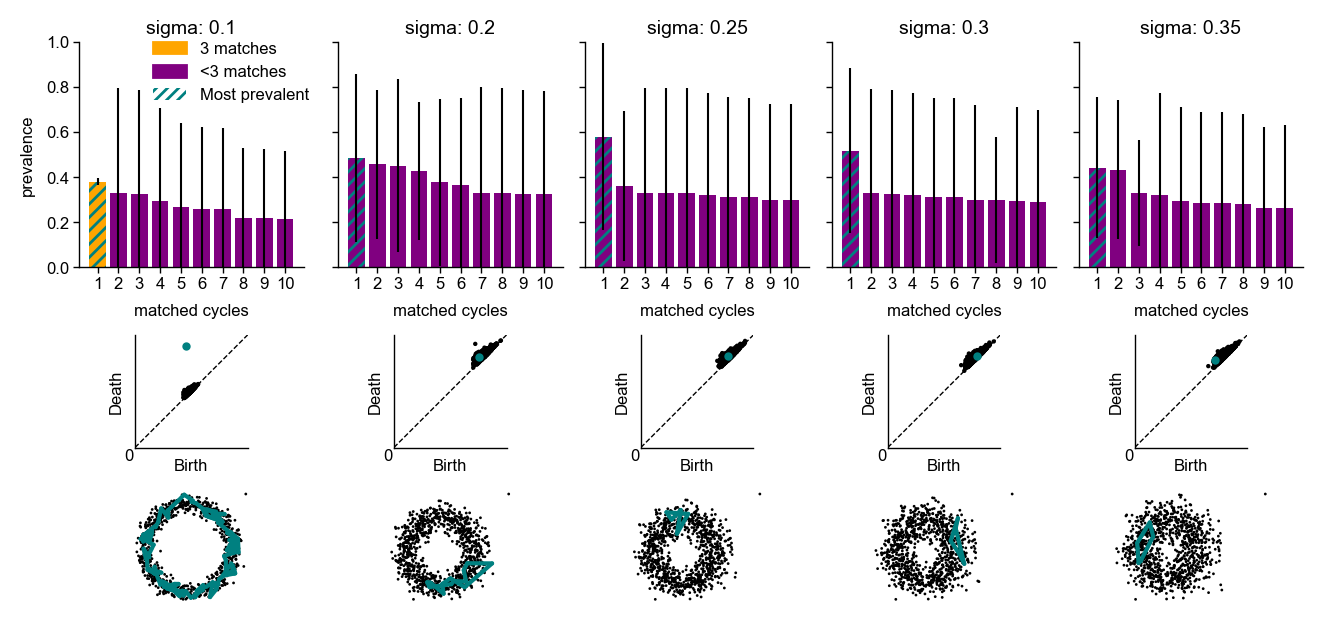

In [14]:
import matplotlib.patches as mpatches
import matplotlib.patches as patches

color_of_first = (0, 0.502, 0.502)

color_matched = (1, 0.647, 0)
color_unmatched = (0.502, 0, 0.502)


n_plotted_cycles = 10


fig, ax = plt.subplots(ncols=len(sigmas), nrows=3, figsize=(6.5, 3), height_ratios=[1, 0.5, 0.5])
max_prev_cycle = {}
for i, sigma in enumerate(sigmas):
    cycle_ids = all_prevs[sigma]["cycle_ids"]
    prevs = all_prevs[sigma]["prevs"]
    
    if len(prevs) < n_plotted_cycles:
        prevs = np.concatenate([prevs, np.zeros((n_plotted_cycles - len(prevs), prevs.shape[1]))], axis=0)
            
    plot_order = np.argsort(prevs.mean(1))[::-1][:n_plotted_cycles]
        
    seeds_found = (prevs[plot_order] > 0).sum(1)
    
    

    for j, prev in enumerate(prevs[plot_order]):
        mean = prev.mean()
        std = prev.std() #if i ==0 else 0
        
        
        edgecolor = color_of_first if j == 0 else None 
        width = 0.8
        c = color_matched if seeds_found[j] > min_seeds else color_unmatched
        if j==0:
            ax[0, i].bar(j+1, mean, width=width, yerr=std, color=c, hatch="/////", edgecolor=edgecolor, linewidth=0)
        else:
            ax[0, i].bar(j+1, mean, width=width, yerr=std, color=c)

    
    max_prev_id = plot_order[0]
    max_prev_cycle[sigma] = cycle_ids[max_prev_id]
    
    if i == 0:
        print(f"sigma: {sigma} 2nd most prev: {np.round(prevs.mean(1)[plot_order[1]],2)} +/- {np.round(prevs.std(1)[plot_order[1]], 2)}")
        
    
    print(f"sigma: {sigma} prev: {np.round(prevs.mean(1)[max_prev_id],2)} +/- {np.round(prevs.std(1)[max_prev_id], 2)}")
    ax[0, i].set_ylabel("prevalence")

    if i > 0:
        ax[0, i].set_yticklabels([])
        ax[0, i].set_ylabel("")

    ax[0, i].set_title(f"sigma: {sigma}")
    ax[0, i].set_ylim(0, 1)
    ax[0, i].set_xlabel("matched cycles")
    ax[0, i].set_xticks(np.arange(1, 11))
    
    
    # Create custom legend labels
    patch1 = mpatches.Patch(color=color_matched, label='3 matches')
    patch2 = mpatches.Patch(color=color_unmatched, label='<3 matches')
    patch3 = mpatches.Patch(facecolor='none', edgecolor=color_of_first, linewidth=0, hatch="//////", label='Most prevalent')
    
    # Add the legend
    ax[0,0].legend(handles=[patch1, patch2, patch3], loc=(0.3, 0.7))
    
    
    # plot diagram and representative
    
    file_name = f"toy_circle_{n}_d_50_ortho_gauss_sigma_{sigma}_seed_{0}_{0}_matching_euclidean"
    res  = load_pkl(os.path.join(root_path, dataset, file_name))
    pca_x = pca.fit_transform(get_toy_data(n=n, dataset="toy_circle", seed=data_seed, d=d, **{"gaussian":{"sigma": sigma}}))
    
    plot_diagrams(["",  np.stack(res[2][0][1], axis=0)],
              ax=ax[1, i],
              plot_only=[1], 
              size=10, 
              color="k", 
              colormap=style_file, # necessary bc plot_diagrams uses the colormap as mpl style
              diagonal=False)
    intersect_at_zero(ax[1, i], dgms=np.stack(res[2][0][1], axis=0))
    
    cycle_id = max_prev_cycle[sigma]
    rep = np.stack(res[2][2][1][cycle_id], axis=0)
    ax[1, i].scatter(*np.array(res[2][0][1][cycle_id]).T, color=color_of_first)
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].legend().set_visible(False)
    
    plot_scatter(ax[2, i], x=pca_x, y="k", s=4, alpha=1, scalebar=False)
        
    plot_edges_on_scatter(ax[2, i], edge_idx = rep, x=pca_x, alpha=1, color=color_of_first, linewidth=1.5)
    
fig.savefig(os.path.join(fig_path, f"toy_circle_{n}_prevalence.pdf"))

sigma: 0.1, GT cycle prev: 0.38 +/- 0.02, matched in 3 seeds
sigma: 0.2, GT cycle prev: 0 +/- 0, matched in 0 seeds
sigma: 0.25, GT cycle prev: 0.11 +/- 0.11, matched in 2 seeds


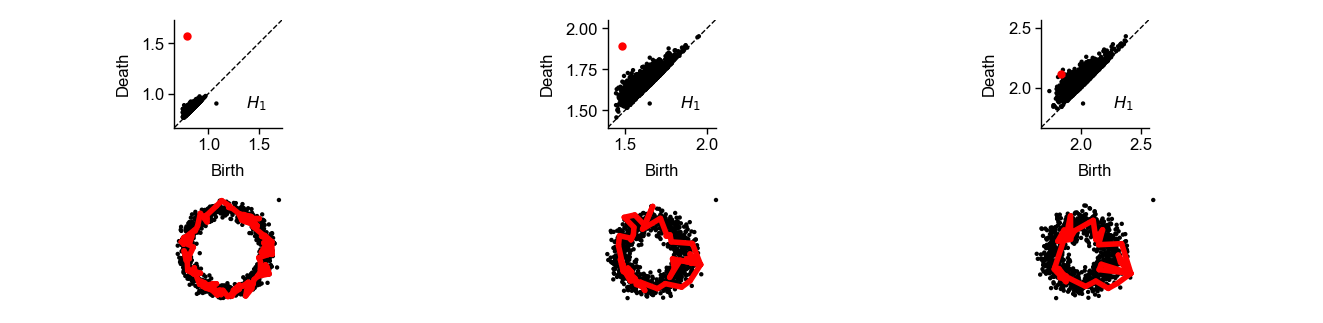

In [129]:
# get prevalences for the GT cycles (at least for some sigmas)
from utils.pd_utils import get_persistent_feature_id

sel_sigmas  =[0.1, 0.2, 0.25]
fig, ax = plt.subplots(ncols=len(sel_sigmas), nrows=2, figsize=(6.5, 1.5))

for i, sigma in enumerate(sel_sigmas):
    file_name = f"toy_circle_{n}_d_50_ortho_gauss_sigma_{sigma}_seed_{0}_{0}_matching_euclidean"
    res  = load_pkl(os.path.join(root_path, dataset, file_name))
    cycle_ids = np.array(res[0])[:, 0]
    
    m = 1 if i < 2 else 2
    pers_feat_id = get_persistent_feature_id(res={"dgms" :["", np.array(res[2][0][1])]}, m=m, dim=1)
    
    
    pca_x = pca.fit_transform(get_toy_data(n=n, dataset="toy_circle", seed=data_seed, d=d, **{"gaussian":{"sigma": sigma}}))
    
    plot_diagrams(["",  np.stack(res[2][0][1], axis=0)],
              ax=ax[0, i],
              plot_only=[1], 
              size=10, 
              color="k", 
              colormap=style_file # necessary bc plot_diagrams uses the colormap as mpl style
              )
    
    cycle_id = pers_feat_id
    rep = np.stack(res[2][2][1][cycle_id], axis=0)
    ax[0, i].scatter(*np.array(res[2][0][1][cycle_id]).T, c="r")
    
    plot_scatter(ax[1, i], x=pca_x, y="k", s=10, alpha=1, scalebar=False)
    
    plot_edges_on_scatter(ax[1, i], edge_idx = rep, x=pca_x, alpha=1, color="r")
    
    
    if cycle_id in all_prevs[sigma]["cycle_ids"]:
        prev_mean = all_prevs[sigma]["prevs"][np.where(all_prevs[sigma]["cycle_ids"] == cycle_id)[0][0]].mean()
        prev_std = all_prevs[sigma]["prevs"][np.where(all_prevs[sigma]["cycle_ids"] == cycle_id)[0][0]].std()
        
        seeds_matched = (all_prevs[sigma]["prevs"][np.where(all_prevs[sigma]["cycle_ids"] == cycle_id)[0][0]] > 0).sum()
        print(f"sigma: {sigma}, GT cycle prev: {np.round(prev_mean,2)} +/- {np.round(prev_std, 2)}, matched in {seeds_matched} seeds")
    else:
        print(f"sigma: {sigma}, GT cycle prev: 0 +/- 0, matched in 0 seeds")
    
    
    
    #print(f"sigma: {sigma}, prev: {prevs[cycle_ids == max_prev_cycle[sigma]]}")

## plot feature which are matched all three times

sigma: 0.1, cycle id: 1251, prev: 0.38 +/- 0.02
sigma: 0.35, cycle id: 168, prev: 0.11 +/- 0.1


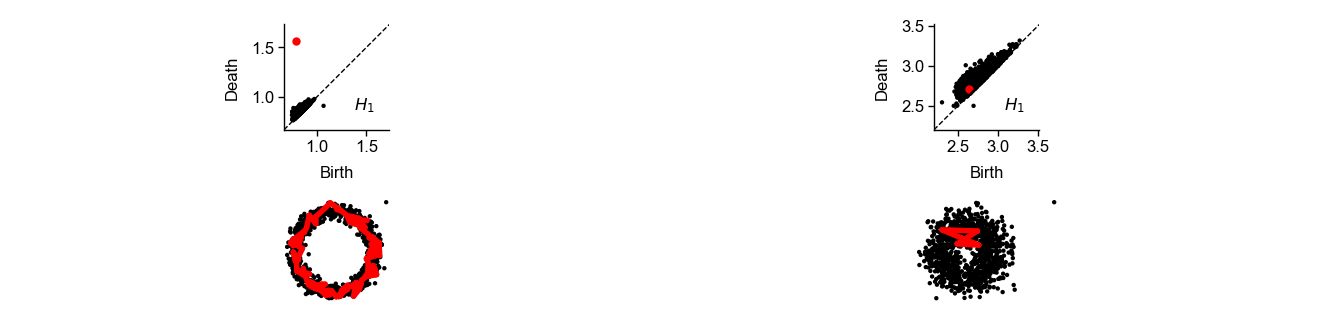

In [132]:
fig, ax  = plt.subplots(ncols=2, nrows=2, figsize=(6.5, 1.5))

for i, sigma in enumerate([0.1, 0.35]):
    cycle_ids = all_prevs[sigma]["cycle_ids"]
    prevs = all_prevs[sigma]["prevs"]
    
    seeds_found = (prevs > 0).sum(1)
    
    file_name = f"toy_circle_{n}_d_50_ortho_gauss_sigma_{sigma}_seed_{0}_{0}_matching_euclidean"
    res  = load_pkl(os.path.join(root_path, dataset, file_name))
    plot_diagrams(["",  np.stack(res[2][0][1], axis=0)],
              ax=ax[0, i],
              plot_only=[1], 
              size=10, 
              color="k", 
              colormap=style_file # necessary bc plot_diagrams uses the colormap as mpl style
              )
    
    if np.any(seeds_found > min_seeds):
        for j, cycle_id in enumerate(cycle_ids[seeds_found > min_seeds]):
            ax[0, i].scatter(*np.array(res[2][0][1][cycle_id]).T, c="r")
            
            pca_x = pca.fit_transform(get_toy_data(n=n, dataset="toy_circle", seed=data_seed, d=d, **{"gaussian":{"sigma": sigma}}))
            plot_scatter(ax[1, i], x=pca_x, y="k", s=10, alpha=1, scalebar=False)
            plot_edges_on_scatter(
                ax[1, i], edge_idx = np.stack(res[2][2][1][cycle_id], axis=0), x=pca_x, alpha=1, color="r"
            )
            
            print(f"sigma: {sigma}, cycle id: {cycle_id}, prev: {np.round(prevs[cycle_ids == cycle_id].mean(),2)} +/- {np.round(prevs[cycle_ids == cycle_id].std(), 2)}")

# diffusion distance

In [15]:
seeds = [0, 1, 2]
sigmas = [0.1, 0.2, 0.25, 0.3, 0.35]

all_prevs = {}
n=1000


for sigma in sigmas:
    cycle_ids = []
    
    # get all matched cycles 
    for seed in seeds:
        file_name = f"toy_circle_{n}_d_50_ortho_gauss_sigma_{sigma}_seed_{data_seed}_{seed}_matching_diffusion_k_15_t_8_kernel_sknn_include_self_False"
        res  = load_pkl(os.path.join(root_path, dataset, file_name))
        matches_x = np.array(res[0])[:, 0]
        times.append(res[-1])
        
        cycle_ids.append(matches_x)
    cycle_ids = np.concatenate(cycle_ids)
    
    cycle_ids = np.unique(cycle_ids)
    
    # get prevalances for matched cycles
    prevs = np.zeros((len(cycle_ids), len(seeds)))

    for seed in seeds:
        file_name = f"toy_circle_{n}_d_50_ortho_gauss_sigma_{sigma}_seed_{data_seed}_{seed}_matching_diffusion_k_15_t_8_kernel_sknn_include_self_False"

        res  = load_pkl(os.path.join(root_path, dataset, file_name))
        matches_x = np.array(res[0])[:, 0]
        
        for i, cycle_id in enumerate(matches_x):
            ordered_ind = np.where(cycle_ids == cycle_id)[0][0]
            prevs[ordered_ind, seed] = res[1][i]
    all_prevs[sigma] = {"cycle_ids": cycle_ids, "prevs": prevs}

In [16]:
# print ids of cycles matched in more than one seed

min_seeds = 2

multi_matched_cycles = {}
for sigma in sigmas:
    cycle_ids = all_prevs[sigma]["cycle_ids"]
    prevs = all_prevs[sigma]["prevs"]
    
    seeds_found = (prevs > 0).sum(1)
    
    multi_matched_cycles[sigma] = cycle_ids[seeds_found > min_seeds]
    
    if np.any(seeds_found > min_seeds):
        print(f"sigma: {sigma}, cycle ids:{multi_matched_cycles[sigma] }")
    else:
        print(f"sigma: {sigma}")
        print(f"No cycle found in more than {min_seeds} seed")

sigma: 0.1, cycle ids:[116]
sigma: 0.2, cycle ids:[188]
sigma: 0.25, cycle ids:[203]
sigma: 0.3, cycle ids:[231]
sigma: 0.35, cycle ids:[133 213 222 230 257]


sigma: 0.1 2nd most prev: 0.0 +/- 0.0
sigma: 0.1 prev: 0.91 +/- 0.02
sigma: 0.2 prev: 0.89 +/- 0.06
sigma: 0.25 prev: 0.71 +/- 0.14
sigma: 0.3 prev: 0.42 +/- 0.16
sigma: 0.35 prev: 0.35 +/- 0.13


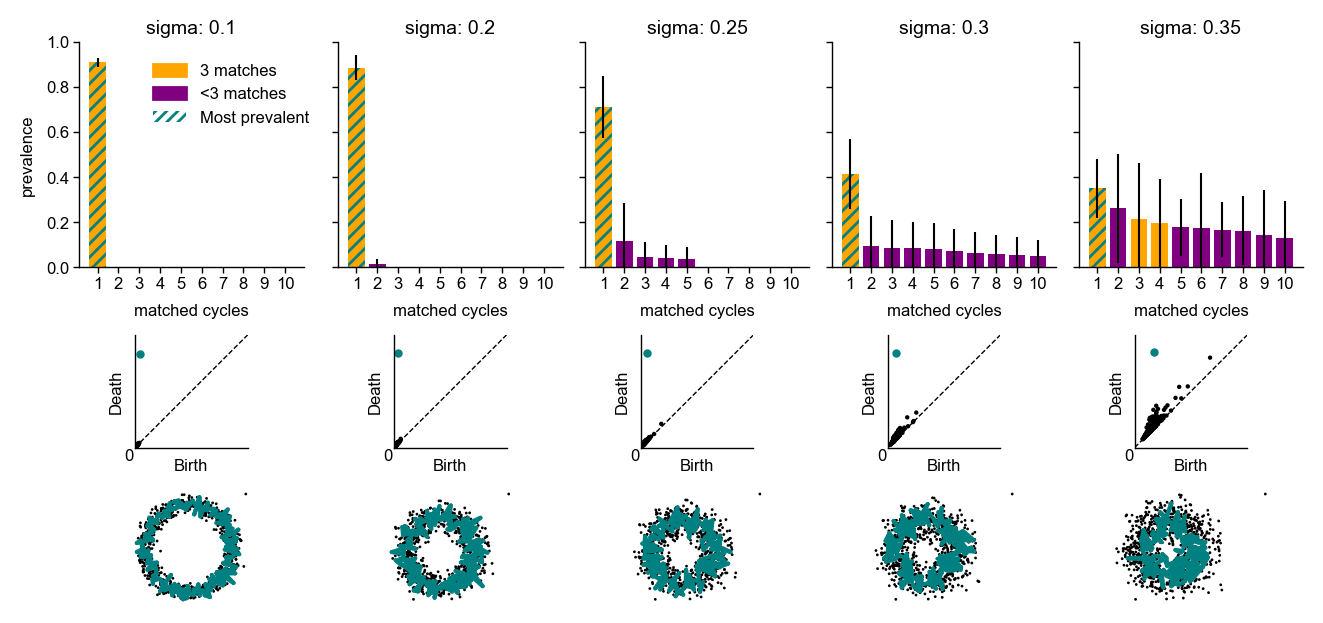

In [18]:
import matplotlib.patches as mpatches

color_of_first = (0, 0.502, 0.502)

color_matched = (1, 0.647, 0)
color_unmatched = (0.502, 0, 0.502)


n_plotted_cycles = 10


fig, ax = plt.subplots(ncols=len(sigmas), nrows=3, figsize=(6.5, 3), height_ratios=[1, 0.5, 0.5])
max_prev_cycle = {}
for i, sigma in enumerate(sigmas):
    cycle_ids = all_prevs[sigma]["cycle_ids"]
    prevs = all_prevs[sigma]["prevs"]
    
    if len(prevs) < n_plotted_cycles:
        prevs = np.concatenate([prevs, np.zeros((n_plotted_cycles - len(prevs), prevs.shape[1]))], axis=0)
            
    plot_order = np.argsort(prevs.mean(1))[::-1][:n_plotted_cycles]
        
    seeds_found = (prevs[plot_order] > 0).sum(1)
    
    

    for j, prev in enumerate(prevs[plot_order]):
        mean = prev.mean()
        std = prev.std() #if i ==0 else 0
        
        
        edgecolor = color_of_first if j == 0 else None 
        width = 0.8
        c = color_matched if seeds_found[j] > min_seeds else color_unmatched
        if j==0:
            ax[0, i].bar(j+1, mean, width=width, yerr=std, color=c, hatch="/////", edgecolor=edgecolor, linewidth=0)
        else:
            ax[0, i].bar(j+1, mean, width=width, yerr=std, color=c)

    
    max_prev_id = plot_order[0]
    max_prev_cycle[sigma] = cycle_ids[max_prev_id]
    
    if i == 0:
        print(f"sigma: {sigma} 2nd most prev: {np.round(prevs.mean(1)[plot_order[1]],2)} +/- {np.round(prevs.std(1)[plot_order[1]], 2)}")
        
    
    print(f"sigma: {sigma} prev: {np.round(prevs.mean(1)[max_prev_id],2)} +/- {np.round(prevs.std(1)[max_prev_id], 2)}")
    ax[0, i].set_ylabel("prevalence")

    if i > 0:
        ax[0, i].set_yticklabels([])
        ax[0, i].set_ylabel("")

    ax[0, i].set_title(f"sigma: {sigma}")
    ax[0, i].set_ylim(0, 1)
    ax[0, i].set_xlabel("matched cycles")
    ax[0, i].set_xticks(np.arange(1, 11))
    
    
    # Create custom legend labels
    patch1 = mpatches.Patch(color=color_matched, label='3 matches')
    patch2 = mpatches.Patch(color=color_unmatched, label='<3 matches')
    patch3 = mpatches.Patch(facecolor='none', edgecolor=color_of_first, linewidth=0, hatch="//////", label='Most prevalent')
    
    # Add the legend
    ax[0,0].legend(handles=[patch1, patch2, patch3], loc=(0.3, 0.6))
    
    
    # plot diagram and representative
    
    file_name = f"toy_circle_{n}_d_50_ortho_gauss_sigma_{sigma}_seed_{0}_{0}_matching_diffusion_k_15_t_8_kernel_sknn_include_self_False"
    res  = load_pkl(os.path.join(root_path, dataset, file_name))
    pca_x = pca.fit_transform(get_toy_data(n=n, dataset="toy_circle", seed=data_seed, d=d, **{"gaussian":{"sigma": sigma}}))
    
    plot_diagrams(["",  np.stack(res[2][0][1], axis=0)],
              ax=ax[1, i],
              plot_only=[1], 
              size=10, 
              color="k", 
              colormap=style_file, # necessary bc plot_diagrams uses the colormap as mpl style
              diagonal=False)
    intersect_at_zero(ax[1, i], dgms=np.stack(res[2][0][1], axis=0))
    
    cycle_id = max_prev_cycle[sigma]
    rep = np.stack(res[2][2][1][cycle_id], axis=0)
    ax[1, i].scatter(*np.array(res[2][0][1][cycle_id]).T, color=color_of_first)
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].legend().set_visible(False)
    
    plot_scatter(ax[2, i], x=pca_x, y="k", s=4, alpha=1, scalebar=False)
        
    plot_edges_on_scatter(ax[2, i], edge_idx = rep, x=pca_x, alpha=1, color=color_of_first, linewidth=1.5)
    
fig.savefig(os.path.join(fig_path, f"toy_circle_{n}_prevalence_diffusion.pdf"))

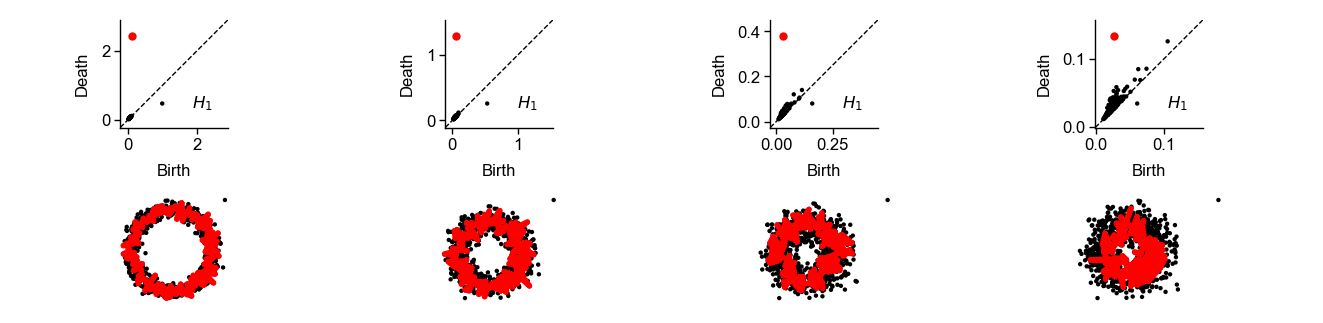

In [340]:
# plot most prevalent feature

fig, ax = plt.subplots(ncols=len(sigmas), nrows=2, figsize=(6.5, 1.5))

for i, sigma in enumerate(sigmas):
    file_name = f"toy_circle_{n}_d_50_ortho_gauss_sigma_{sigma}_seed_{0}_{0}_matching_diffusion_k_15_t_8_kernel_sknn_include_self_False"
    res  = load_pkl(os.path.join(root_path, dataset, file_name))
    pca_x = pca.fit_transform(get_toy_data(n=n, dataset="toy_circle", seed=data_seed, d=d, **{"gaussian":{"sigma": sigma}}))
    
    plot_diagrams(["",  np.stack(res[2][0][1], axis=0)],
              ax=ax[0, i],
              plot_only=[1], 
              size=10, 
              color="k", 
              colormap=style_file # necessary bc plot_diagrams uses the colormap as mpl style
              )
    
    cycle_id = max_prev_cycle[sigma]
    rep = np.stack(res[2][2][1][cycle_id], axis=0)
    ax[0, i].scatter(*np.array(res[2][0][1][cycle_id]).T, c="r")
    
    plot_scatter(ax[1, i], x=pca_x, y="k", s=10, alpha=1, scalebar=False)
    
    plot_edges_on_scatter(ax[1, i], edge_idx = rep, x=pca_x, alpha=1, color="r")
